In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import hvplot.xarray  # noqa
import seaborn as sns
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed, compute
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')



sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
def pds_parameters(xr_data):
    """
    Compute the psd parameters
    :param xr_data: partice size distribution in # L-1 um-1
    :return: list with lwc, dm, nw, z, and r
    """
    xr_data['lwc_cum'] = xr_data.lwc.sum('diameter')
    xr_data['dbz_t'] = 10 * np.log10(xr_data.z.sum('diameter'))
    xr_data['dbz_t_ku'] = 10 * np.log10(xr_data.refl_ku.sum('diameter'))    
    xr_data['dbz_t_ka'] = 10 * np.log10(xr_data.refl_ka.sum('diameter'))    
    xr_data['dbz_t_w'] = 10 * np.log10(xr_data.refl_w.sum('diameter'))    
    xr_data['log10_nw'] = np.log10(xr_data.nw)
    xr_data['Att_ku'] = xr_data.A_ku.sum('diameter')
    xr_data['Att_ka'] = xr_data.A_ka.sum('diameter')
    xr_data['Att_w'] = xr_data.A_w.sum('diameter')
    xr_data = xr_data.where(xr_data.lwc_cum < 15, drop=True)
    return xr_data

def add_colorbar_outside(im, ax, label):
    fig = ax.get_figure()
    bbox = ax.get_position() #bbox contains the [x0 (left), y0 (bottom), x1 (right), y1 (top)] of the axis.
    width = 0.01
    eps = 0.06 #margin between plot and colorbar
    # [left most position, bottom position, width, height] of color bar.
    cax = fig.add_axes([bbox.x1 + eps, bbox.y0, width, bbox.height])
    cbar = fig.colorbar(im, cax=cax, label=label)
    
    
def get_eventst(ds, time_lenght=30, time_break=30, tot_counts=10):
    """
    param ds: Xarray dataset with count bin (cnt_bin) matrix
    param time_lenght: Minimum duration of the event
    param time_break: Maximum duration of a time break between events
    param tot_counts: Minimum total number of particles within the count bin spectra
    """
    ev = ds.cnt_bin.sum('diameter').where(ds.cnt_bin.sum('diameter') > tot_counts)
    ev = ev[ev.notnull()]
    a = ev.time.diff('time').to_dataframe('date') 
    sec = pd.Timedelta('30S') 
    breaks = a >= sec
    groups = breaks.cumsum()
    start = [i[1].index.min() for i in groups.groupby('date') if i[1].shape[0] > time_lenght]
    end = [i[1].index.max() for i in groups.groupby('date') if i[1].shape[0] > time_lenght]
    return start, end

In [3]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [4]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict, 256)

In [5]:
cluster = SLURMCluster(queue="seseml",
                       memory='20GB',
                       cores=20,
                       processes=1,
                       walltime='24:00:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7799'})

cluster.scale(jobs=4)
cluster

In [6]:
client = Client(cluster)
client

<Client: 'tcp://172.22.179.3:7223' processes=0 threads=0, memory=0 B>

In [7]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1624572    seseml dask-wor alfonso8  R       0:00      1 keeling-g19
           1624573    seseml dask-wor alfonso8  R       0:00      1 keeling-g20
           1624574    seseml dask-wor alfonso8  R       0:00      1 keeling-g21
           1624575    seseml dask-wor alfonso8  R       0:00      1 keeling-g22


In [8]:
aircraft = 'Lear'
aircraft2 = 'Learjet'

In [9]:
store5 = f"{path_data}/cloud_probes/zarr/Page0_Learjet.zarr"
store8 = f"{path_data}/cloud_probes/zarr/combined_psd_{aircraft}_600_1000_1_bins_merged.zarr"


In [10]:
xr_comb_350  = xr.open_zarr(store8)
xr_comb_350.attrs['instrument'] = 'combined_psd_2ds_hvps'

In [13]:
# ds = pds_parameters(xr_comb_350).sel(time=slice('2019-09-07', '2019-09-10'))
xr_comb_350["dbz_t"] = 10 * np.log10(xr_comb_350.z.sum('diameter'))
xr_comb_350 = xr_comb_350.where(xr_comb_350.dfr > -0.5)
df = xr_comb_350.to_dataframe().dropna()

Text(0, 0.5, '$log10(Nw)$')

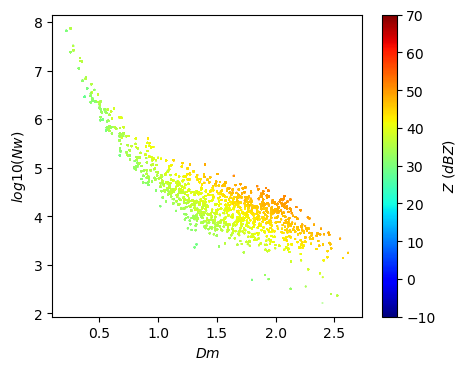

In [14]:
fig, ax = plt.subplots(dpi=100, figsize=(5, 4),)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['dbz_t'], cmap='jet', vmin=-10, vmax=70, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Z \ (dBZ)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$log10(Nw)$')


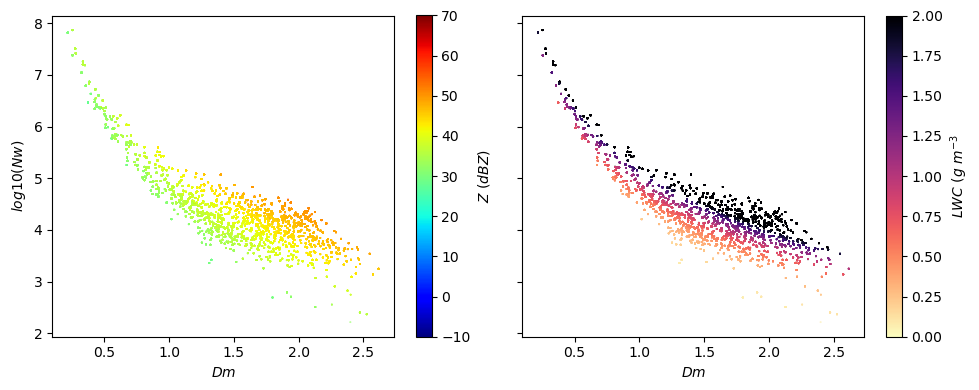

In [15]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(10, 4), sharey=True)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['dbz_t'], cmap='jet', vmin=-10, vmax=70, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Z \ (dBZ)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$log10(Nw)$')

sc = ax1.scatter(df['dm'], df['log10_nw'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=2, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_xlabel(r'$Dm$')
plt.tight_layout()
plt.show()

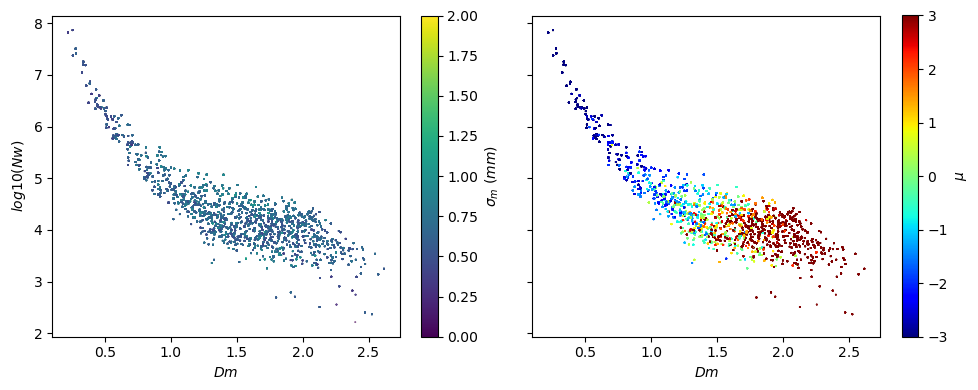

In [16]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(10, 4), sharey=True)
sc = ax1.scatter(df['dm'], df['log10_nw'], c=df['mu'], cmap='jet', vmin=-3, vmax=3, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$\mu$')
ax1.set_xlabel(r'$Dm$')

sc = ax.scatter(df['dm'], df['log10_nw'], c=df['sigma'], cmap='viridis', vmin=0, vmax=2, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$\sigma_m \ (mm)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$log10(Nw)$')
plt.tight_layout()
plt.show()

$$
\mu =  \frac{Dm^2}{\sigma^2_m} - 4
$$

In [17]:
print(df['mu'].describe())

count    4.091500e+04
mean              inf
std               NaN
min     -3.791966e+00
25%     -1.547621e+00
50%      3.944102e-01
75%      3.510146e+00
max               inf
Name: mu, dtype: float64


In [18]:
df_sub = df
df_sub.replace([np.inf, -np.inf], np.nan, inplace=True)
df_sub.dropna(how="all", inplace=True)
df_sub = df_sub[df_sub['mu'] < 20]

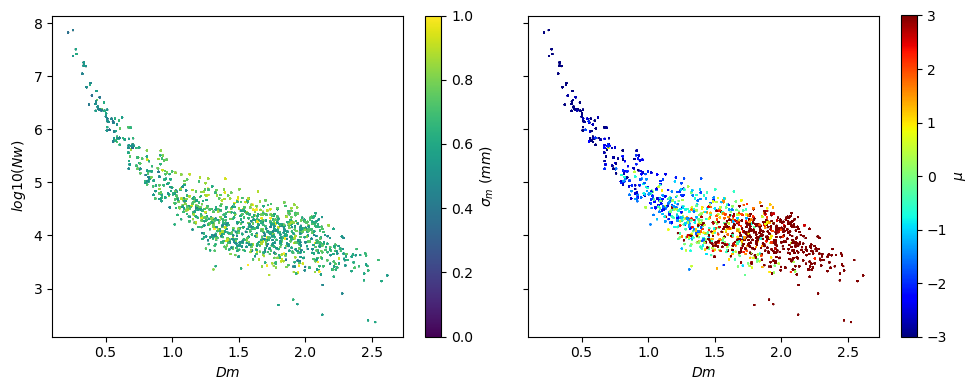

In [19]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(10, 4), sharey=True)
sc = ax1.scatter(df_sub['dm'], df_sub['log10_nw'], c=df_sub['mu'], cmap='jet', vmin=-3, vmax=3, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$\mu$')
ax1.set_xlabel(r'$Dm$')

sc = ax.scatter(df_sub['dm'], df_sub['log10_nw'], c=df_sub['sigma'], cmap='viridis', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$\sigma_m \ (mm)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$log10(Nw)$')
plt.tight_layout()
plt.show()

In [20]:
df_sub['mu'].describe()

count    40748.000000
mean         1.399819
std          3.956555
min         -3.791966
25%         -1.549990
50%          0.346997
75%          3.484119
max         19.930510
Name: mu, dtype: float64

In [21]:
_dates = df['mu'].nlargest(1000).index.get_level_values(0).unique()
%store _dates

Stored '_dates' (DatetimeIndex)


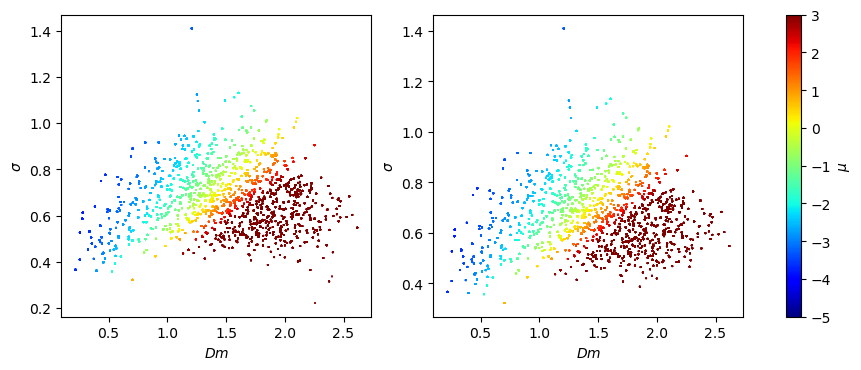

In [22]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(11, 4))

sc = ax.scatter(df['dm'] , df['sigma'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
fig.colorbar(sc, ax=[ax, ax1], label=r'$\mu$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$\sigma$')

sc = ax1.scatter(df_sub['dm'] , df_sub['sigma'], c=df_sub['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
# fig.colorbar(sc, ax=ax1, label=r'$\mu$')
ax1.set_xlabel(r'$Dm$')
ax1.set_ylabel(r'$\sigma$')
# plt.tight_layout()
plt.show()

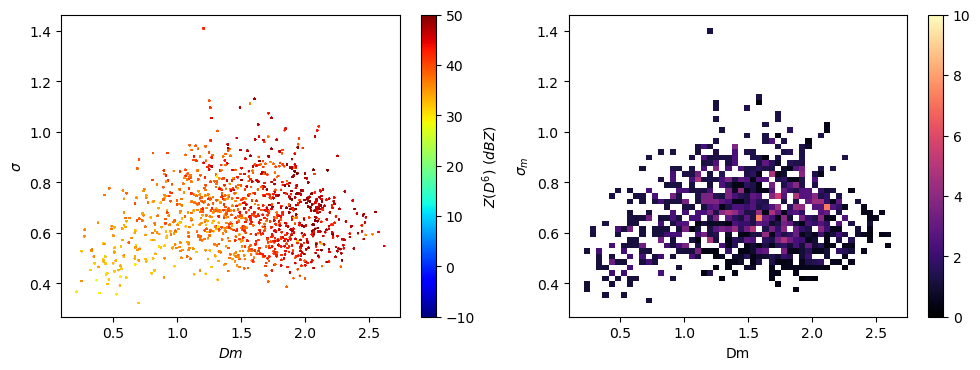

In [23]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 4))

sc = ax.scatter(df_sub['dm'] , df_sub['sigma'], c=df_sub['dbz_t'], cmap='jet', vmin=-10, vmax=50, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Z (D^6) \ (dBZ)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$\sigma$')

sns.histplot(data=df_sub, x="dm", y='sigma', bins=(50, 50), cmap='magma', ax=ax1, cbar=True,\
             log_scale=(False, False), stat='density', vmin=0, vmax=10)
ax1.set_xlabel('Dm')
ax1.set_ylabel(r'$\sigma_m$')
plt.show()



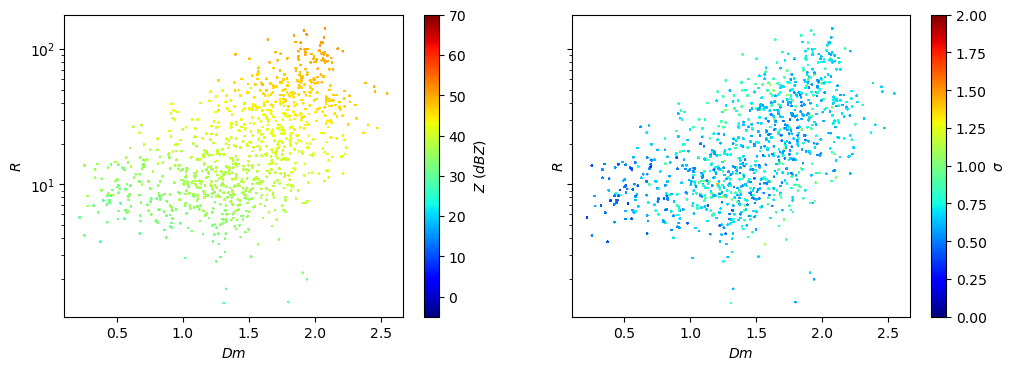

In [24]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 4), sharey=True)
sc = ax.scatter(df['dm'][df['mu'] < 10], df['r'][df['mu'] < 10], c=df['dbz_t'][df['mu'] < 10], cmap='jet', 
                vmin=-5, vmax=70, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Z \ (dBZ)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$R$')
ax.set_yscale('log')
# ax.set_xscale('log')

sc = ax1.scatter(df['dm'][df['mu'] < 10] , df['r'][df['mu'] < 10], c=df['sigma'][df['mu'] < 10], cmap='jet', vmin=0, vmax=2, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$\sigma$')
ax1.set_xlabel(r'$Dm$')
ax1.set_ylabel(r'$R$')
ax1.set_yscale('log')
# ax1.set_xscale('log')


Text(0, 0.5, '$R$')

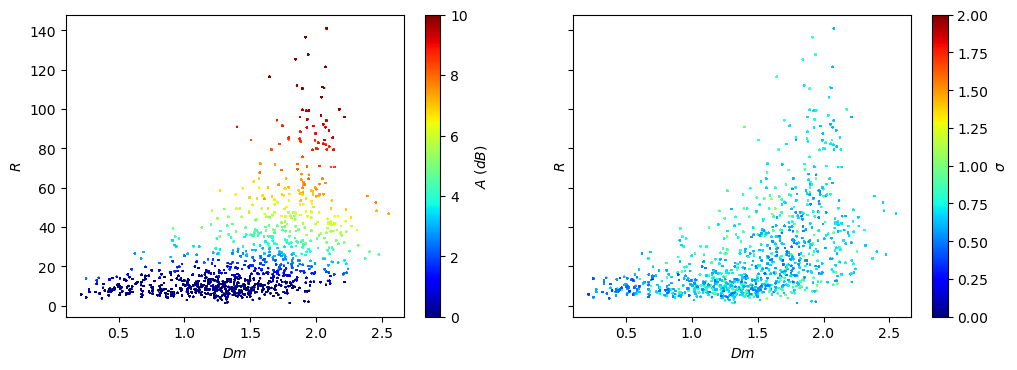

In [25]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 4), sharey=True)
sc = ax.scatter(df['dm'][df['mu'] < 10], df['r'][df['mu'] < 10], c=df['Att_ku'][df['mu'] < 10], cmap='jet', 
                vmin=0, vmax=10, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$A \ (dB)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$R$')
# ax.set_yscale('log')
# ax.set_xscale('log')

sc = ax1.scatter(df['dm'][df['mu'] < 10] , df['r'][df['mu'] < 10], c=df['sigma'][df['mu'] < 10], cmap='jet', vmin=0, vmax=2, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$\sigma$')
ax1.set_xlabel(r'$Dm$')
ax1.set_ylabel(r'$R$')
# ax1.set_yscale('log')
# ax1.set_xscale('log')

(1.0568101795476463, 150)

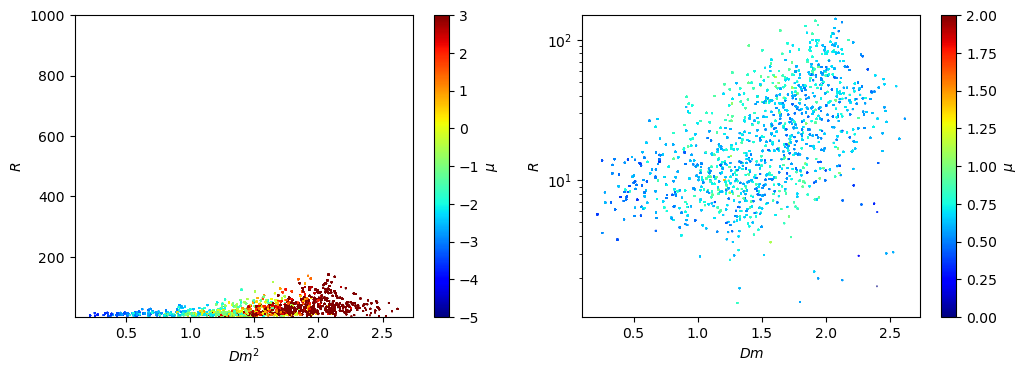

In [26]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 4))
sc = ax.scatter(df['dm'], df['r'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$\mu$')
ax.set_xlabel(r'$Dm^2$')
ax.set_ylabel(r'$R$')
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(1e-5, 1e3)

sc = ax1.scatter(df['dm'] , df['r'], c=df['sigma'], cmap='jet', vmin=0, vmax=2, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$\mu$')
ax1.set_xlabel(r'$Dm$')
ax1.set_ylabel(r'$R$')
ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.set_ylim(0, 150)

(1e-05, 1000.0)

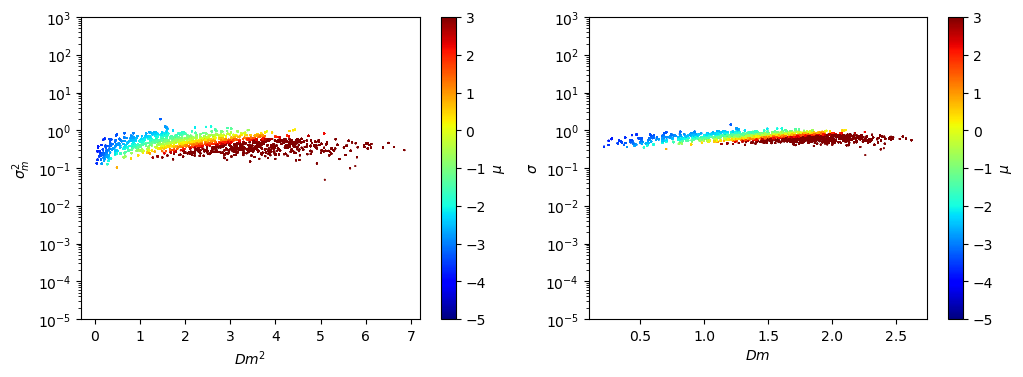

In [27]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 4))
sc = ax.scatter(df['dm'] ** 2, df['sigmasqr'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$\mu$')
ax.set_xlabel(r'$Dm^2$')
ax.set_ylabel(r'$\sigma^2_m$')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_ylim(1e-5, 1e3)

sc = ax1.scatter(df['dm'] , df['sigma'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$\mu$')
ax1.set_xlabel(r'$Dm$')
ax1.set_ylabel(r'$\sigma$')
ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.set_ylim(1e-5, 1e3)

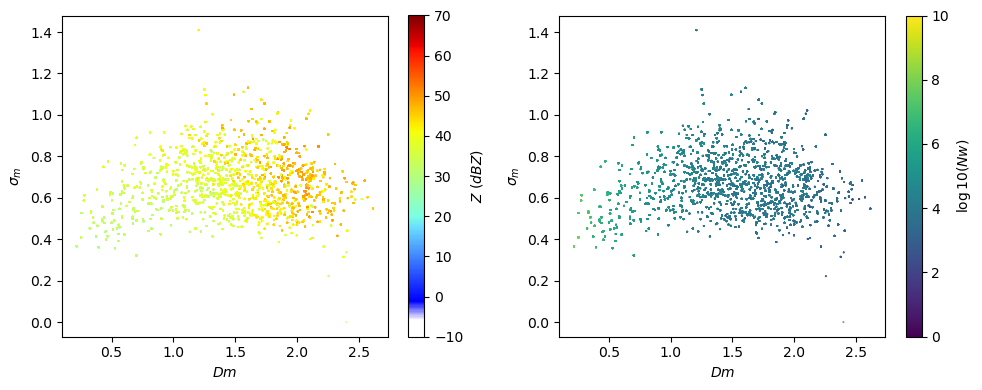

In [28]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(10, 4),)
sc = ax.scatter(df['dm'], df['sigma'], c=df['dbz_t'], cmap=my_cmap, vmin=-10, vmax=70, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Z \ (dBZ)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$\sigma_m$')

sc = ax1.scatter(df['dm'], df['sigma'], c=df['log10_nw'], cmap='viridis', vmin=0, vmax=10, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$\log10(Nw)$')
ax1.set_xlabel(r'$Dm$')
ax1.set_ylabel(r"$\sigma_m$")
plt.tight_layout()
plt.show()

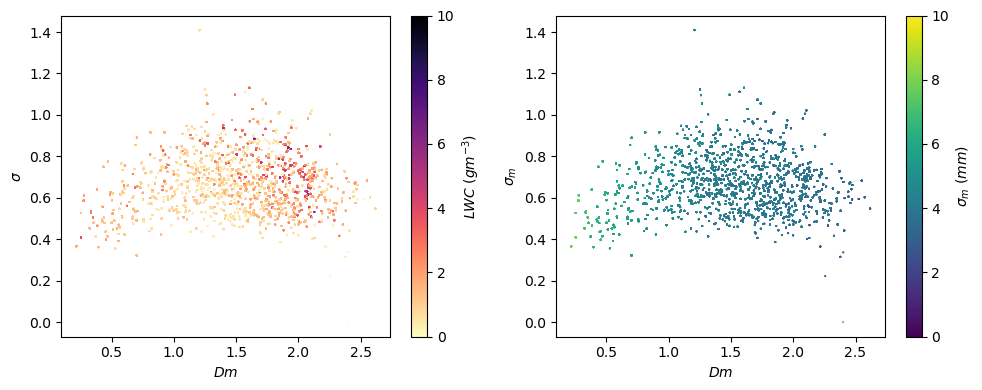

In [29]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(10, 4),)
sc = ax.scatter(df['dm'], df['sigma'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=10, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$LWC \ (gm^{-3})$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$\sigma$')

sc = ax1.scatter(df['dm'], df['sigma'], c=df['log10_nw'], cmap='viridis', vmin=0, vmax=10, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$\sigma_m \ (mm)$')
ax1.set_xlabel(r'$Dm$')
ax1.set_ylabel(r"$\sigma_m$")
plt.tight_layout()
plt.show()

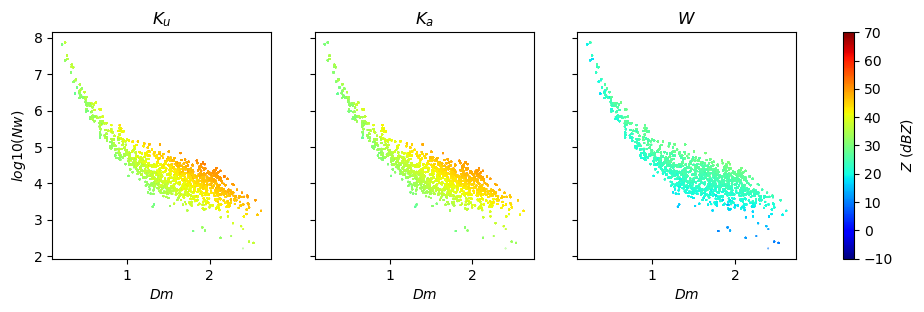

In [30]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dm'], df['log10_nw'], c=df['dbz_t_ka'], cmap='jet', vmin=-10, vmax=70, s=0.1)
# fig.colorbar(sc, ax=ax, label=r'$Z_{Ka} \ (dBZ)$')
ax1.set_xlabel(r'$Dm$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$log10(Nw)$')

sc1 = ax.scatter(df['dm'], df['log10_nw'], c=df['dbz_t_ku'], cmap='jet', vmin=-10, vmax=70, s=0.1)
# fig.colorbar(sc1, ax=ax1, label=r'$Z_{Ku} \ (dBZ)$')
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Dm$')

sc2 = ax2.scatter(df['dm'], df['log10_nw'], c=df['dbz_t_w'], cmap='jet', vmin=-10, vmax=70, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Z \ (dBZ)$')
ax2.set_xlabel(r'$Dm$')
ax2.set_title(r"$W$")
# plt.tight_layout()
plt.show()

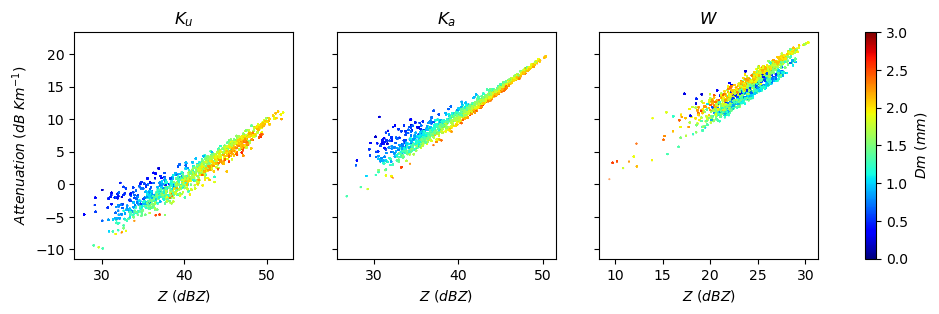

In [31]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dbz_t_ka'], df['Att_ka'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax1.set_xlabel(r'$Z \ (dBZ)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB \ Km^{-1})$')

sc1 = ax.scatter(df['dbz_t_ku'], df['Att_ku'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Z \ (dBZ)$')

sc2 = ax2.scatter(df['dbz_t_w'], df['Att_w'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Dm \ (mm)$')
ax2.set_xlabel(r'$Z \ (dBZ)$')
ax2.set_title(r"$W$")
plt.show()

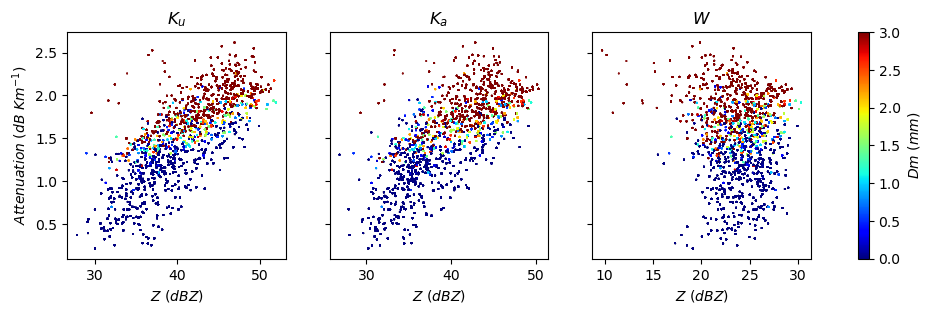

In [32]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dbz_t_ka'], df['dm'], c=df['mu'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax1.set_xlabel(r'$Z \ (dBZ)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB \ Km^{-1})$')

sc1 = ax.scatter(df['dbz_t_ku'], df['dm'], c=df['mu'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Z \ (dBZ)$')

sc2 = ax2.scatter(df['dbz_t_w'], df['dm'], c=df['mu'], cmap='jet', vmin=0, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Dm \ (mm)$')
ax2.set_xlabel(r'$Z \ (dBZ)$')
ax2.set_title(r"$W$")
plt.show()

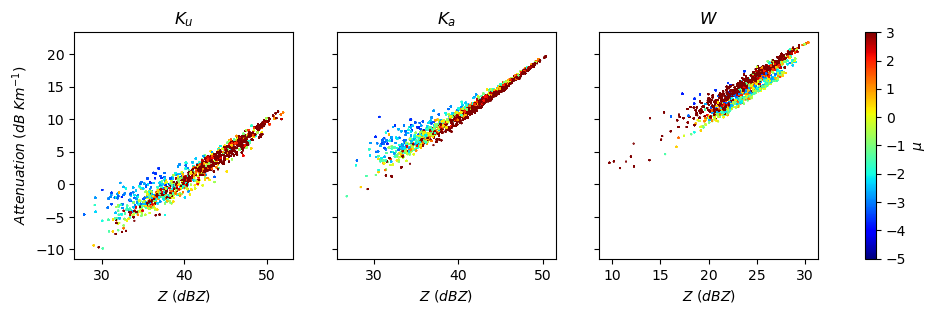

In [33]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dbz_t_ka'], df['Att_ka'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
ax1.set_xlabel(r'$Z \ (dBZ)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB \ Km^{-1})$')

sc1 = ax.scatter(df['dbz_t_ku'], df['Att_ku'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Z \ (dBZ)$')

sc2 = ax2.scatter(df['dbz_t_w'], df['Att_w'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$\mu$')
ax2.set_xlabel(r'$Z \ (dBZ)$')
ax2.set_title(r"$W$")
# ax.set_ylim(-5, 70)
# plt.tight_layout()
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax1.set_xscale('log')
# ax2.set_xscale('log')
plt.show()

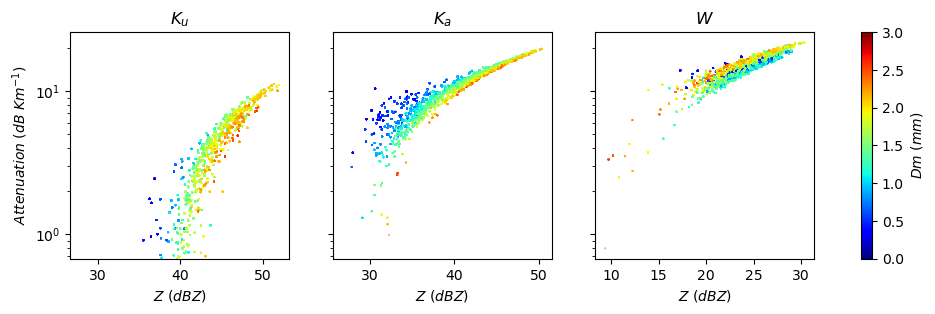

In [34]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dbz_t_ka'], df['Att_ka'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax1.set_xlabel(r'$Z \ (dBZ)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB \ Km^{-1})$')

sc1 = ax.scatter(df['dbz_t_ku'], df['Att_ku'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Z \ (dBZ)$')

sc2 = ax2.scatter(df['dbz_t_w'], df['Att_w'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Dm \ (mm)$')
ax2.set_xlabel(r'$Z \ (dBZ)$')
ax2.set_title(r"$W$")
# plt.tight_layout()
ax.set_yscale('log')
# ax.set_xscale('log')
# ax1.set_xscale('log')
# ax2.set_xscale('log')
plt.show()

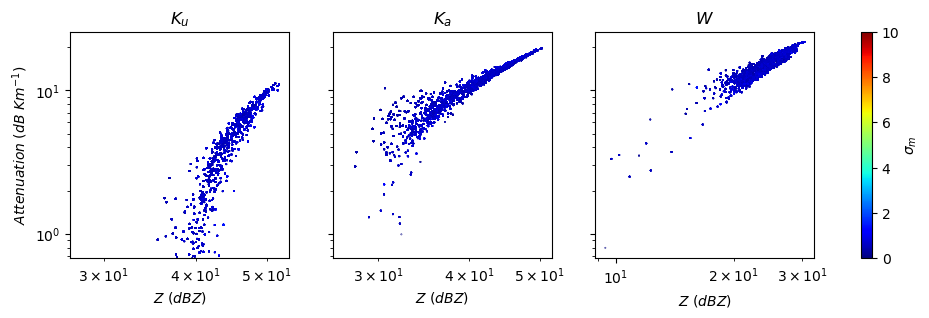

In [35]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dbz_t_ka'], df['Att_ka'], c=df['sigma'], cmap='jet', vmin=0, vmax=10, s=0.1)
ax1.set_xlabel(r'$Z \ (dBZ)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB \ Km^{-1})$')


sc1 = ax.scatter(df['dbz_t_ku'], df['Att_ku'], c=df['sigma'], cmap='jet', vmin=0, vmax=10, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Z \ (dBZ)$')

sc2 = ax2.scatter(df['dbz_t_w'], df['Att_w'], c=df['sigma'],cmap='jet', vmin=0, vmax=10, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$\sigma_m$')
ax2.set_xlabel(r'$Z \ (dBZ)$')
ax2.set_title(r"$W$")
# plt.tight_layout()
ax.set_yscale('log')
ax.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')


plt.show()

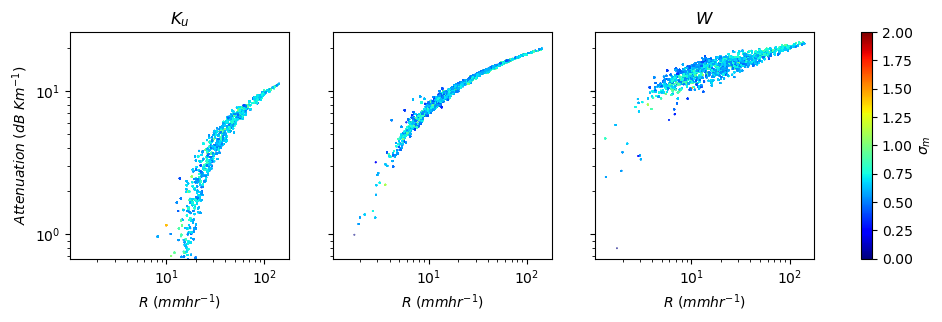

In [36]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['r'], df['Att_ka'], c=df['sigma'], cmap='jet', vmin=0, vmax=2, s=0.1)
ax1.set_xlabel(r'$R \ (mmhr^{-1})$')
ax.set_ylabel(r'$Attenuation \ (dB \ Km^{-1})$')


sc1 = ax.scatter(df['r'], df['Att_ku'], c=df['sigma'], cmap='jet', vmin=0, vmax=2, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$R \ (mmhr^{-1})$')

sc2 = ax2.scatter(df['r'], df['Att_w'], c=df['sigma'],cmap='jet', vmin=0, vmax=2, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$\sigma_m$')
ax2.set_xlabel(r'$R \ (mmhr^{-1})$')
ax2.set_title(r"$W$")
# plt.tight_layout()
ax.set_yscale('log')
ax.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')


plt.show()

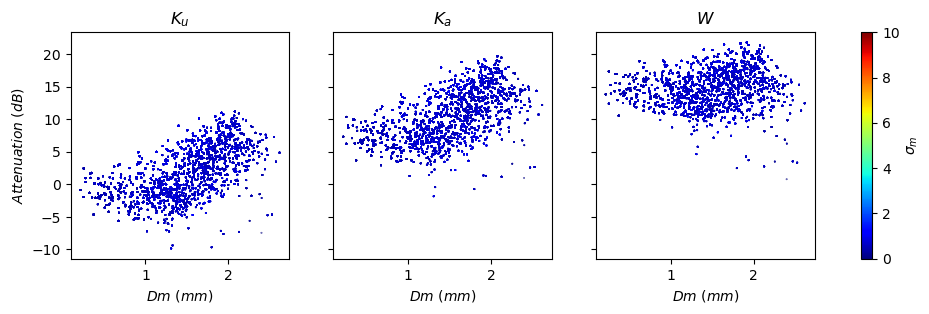

In [37]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dm'], df['Att_ka'], c=df['sigma'], cmap='jet', vmin=0, vmax=10, s=0.1)
ax1.set_xlabel(r'$Dm \ (mm)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB)$')

sc1 = ax.scatter(df['dm'], df['Att_ku'], c=df['sigma'], cmap='jet', vmin=0, vmax=10, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Dm \ (mm)$')

sc2 = ax2.scatter(df['dm'], df['Att_w'], c=df['sigma'],cmap='jet', vmin=0, vmax=10, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$\sigma_m$')
ax2.set_xlabel(r'$Dm \ (mm)$')
ax2.set_title(r"$W$")
# plt.tight_layout()
# ax.set_yscale('log')
plt.show()

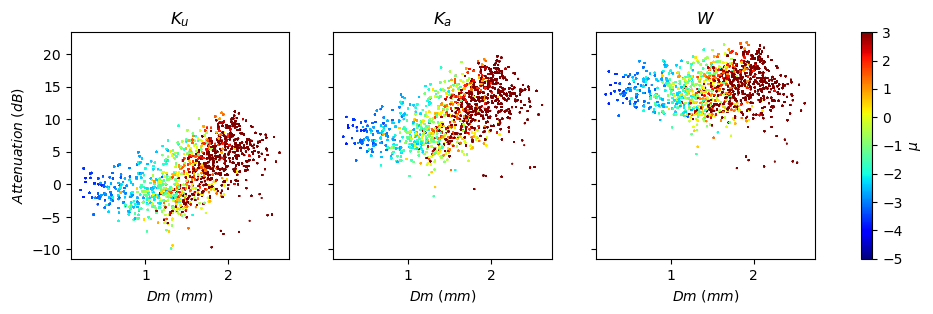

In [38]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dm'], df['Att_ka'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
ax1.set_xlabel(r'$Dm \ (mm)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB)$')

sc1 = ax.scatter(df['dm'], df['Att_ku'], c=df['mu'], cmap='jet', vmin=-5, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Dm \ (mm)$')

sc2 = ax2.scatter(df['dm'], df['Att_w'], c=df['mu'],cmap='jet', vmin=-5, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$\mu$')
ax2.set_xlabel(r'$Dm \ (mm)$')
ax2.set_title(r"$W$")
# plt.tight_layout()
# ax.set_yscale('log')
plt.show()

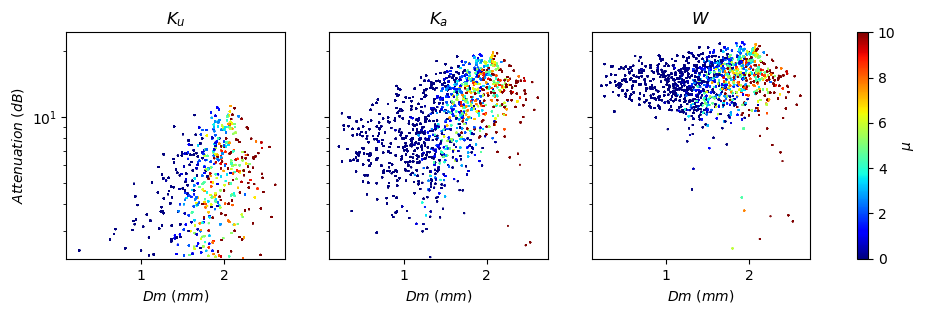

In [39]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dm'], df['Att_ka'], c=df['mu'], cmap='jet', vmin=0, vmax=10, s=0.1)
ax1.set_xlabel(r'$Dm \ (mm)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB)$')

sc1 = ax.scatter(df['dm'], df['Att_ku'], c=df['mu'], cmap='jet', vmin=0, vmax=10, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Dm \ (mm)$')

sc2 = ax2.scatter(df['dm'], df['Att_w'], c=df['mu'],cmap='jet', vmin=0, vmax=10, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$\mu$')
ax2.set_xlabel(r'$Dm \ (mm)$')
ax2.set_title(r"$W$")
# plt.tight_layout()
ax.set_yscale('log')
plt.show()

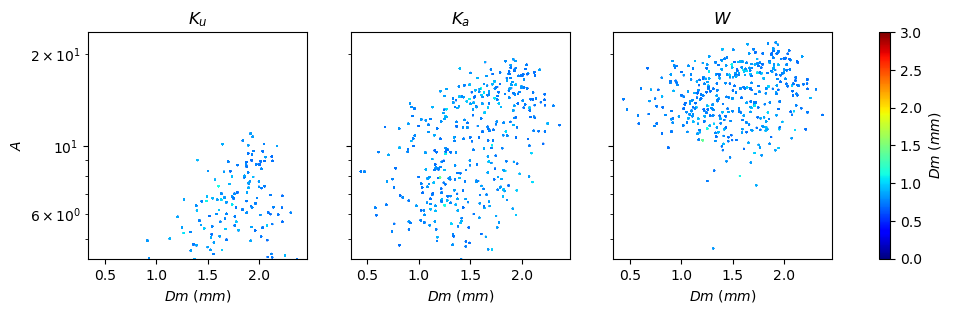

In [40]:
df = xr_comb_350.to_dataframe().dropna()
df = df[df['sigmasqr'] > 0.5]
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dm'], df['Att_ka'], c=df['sigma'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax1.set_xlabel(r'$Dm \ (mm)$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$A$')

sc1 = ax.scatter(df['dm'], df['Att_ku'], c=df['sigma'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Dm \ (mm)$')

sc2 = ax2.scatter(df['dm'], df['Att_w'], c=df['sigma'],cmap='jet', vmin=0, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Dm \ (mm)$')
ax2.set_xlabel(r'$Dm \ (mm)$')
ax2.set_title(r"$W$")
# plt.tight_layout()
ax.set_yscale('log')
plt.show()

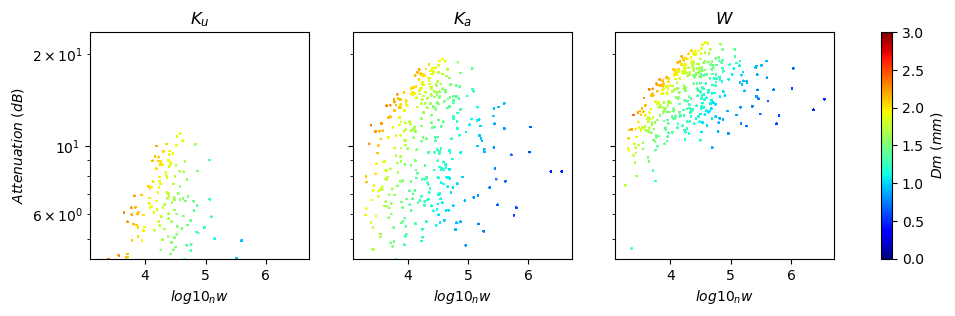

In [41]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['log10_nw'], df['Att_ka'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax1.set_xlabel(r'$log10_nw$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB)$')

sc1 = ax.scatter(df['log10_nw'], df['Att_ku'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$log10_nw$')

sc2 = ax2.scatter(df['log10_nw'], df['Att_w'], c=df['dm'],cmap='jet', vmin=0, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Dm \ (mm)$')
ax2.set_xlabel(r'$log10_nw$')
ax2.set_title(r"$W$")
# plt.tight_layout()
ax.set_yscale('log')
plt.show()

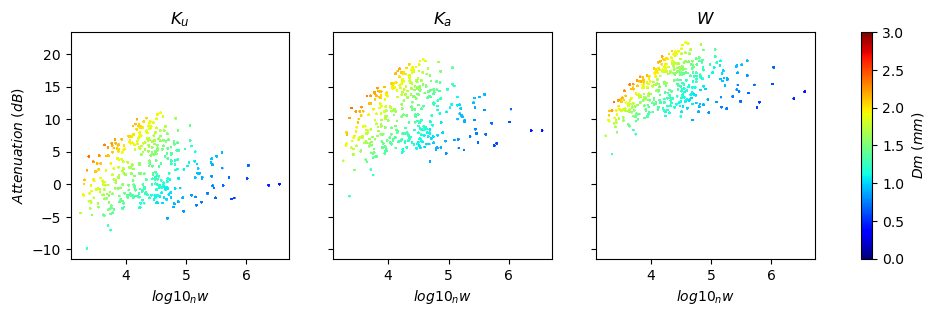

In [42]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['log10_nw'], df['Att_ka'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax1.set_xlabel(r'$log10_nw$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB)$')

sc1 = ax.scatter(df['log10_nw'], df['Att_ku'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$log10_nw$')

sc2 = ax2.scatter(df['log10_nw'], df['Att_w'], c=df['dm'],cmap='jet', vmin=0, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Dm \ (mm)$')
ax2.set_xlabel(r'$log10_nw$')
ax2.set_title(r"$W$")
# plt.tight_layout()
# ax.set_yscale('log')
# ax.set_ylim(0, 50)
plt.show()

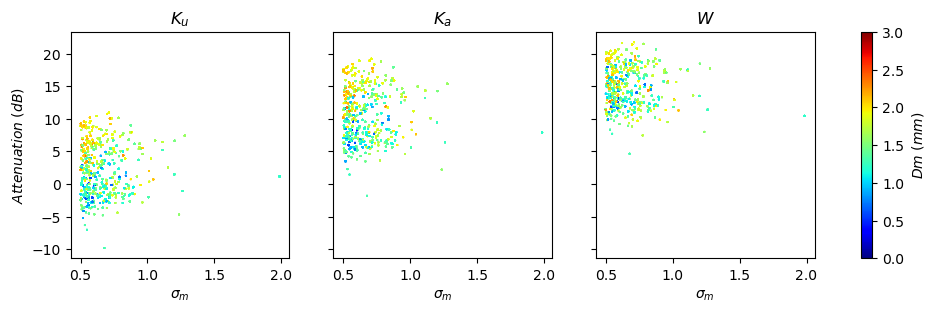

In [43]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['sigmasqr'], df['Att_ka'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax1.set_xlabel(r'$\sigma_m$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB)$')

sc1 = ax.scatter(df['sigmasqr'], df['Att_ku'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$\sigma_m$')

sc2 = ax2.scatter(df['sigmasqr'], df['Att_w'], c=df['dm'],cmap='jet', vmin=0, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Dm \ (mm)$')
ax2.set_xlabel(r'$\sigma_m$')
ax2.set_title(r"$W$")
# plt.tight_layout()
# ax.set_yscale('log')
plt.show()

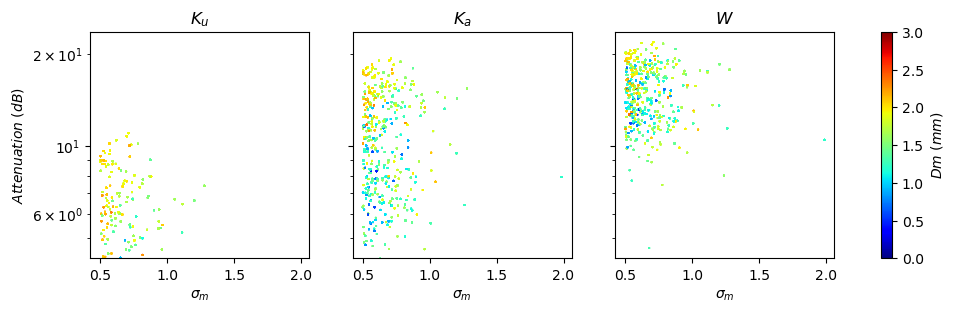

In [44]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['sigmasqr'], df['Att_ka'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax1.set_xlabel(r'$\sigma_m$')
ax1.set_title(r"$K_a$")
ax.set_ylabel(r'$Attenuation \ (dB)$')

sc1 = ax.scatter(df['sigmasqr'], df['Att_ku'], c=df['dm'], cmap='jet', vmin=0, vmax=3, s=0.1)
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$\sigma_m$')

sc2 = ax2.scatter(df['sigmasqr'], df['Att_w'], c=df['dm'],cmap='jet', vmin=0, vmax=3, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Dm \ (mm)$')
ax2.set_xlabel(r'$\sigma_m$')
ax2.set_title(r"$W$")
# plt.tight_layout()
ax.set_yscale('log')
plt.show()

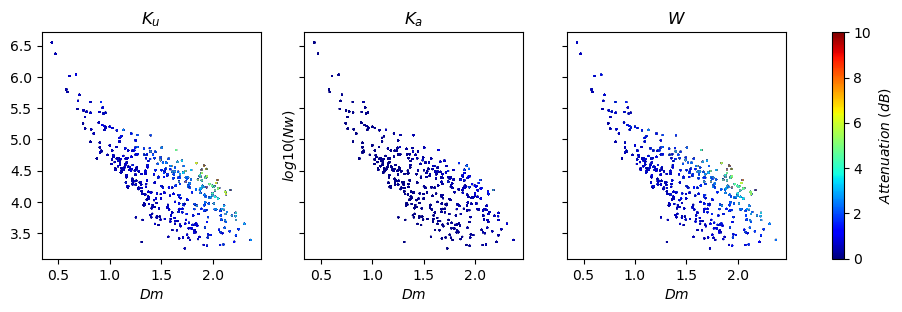

In [45]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dm'], df['log10_nw'], c=df['A_ku'], cmap='jet', vmin=0, vmax=10, s=0.1)
# fig.colorbar(sc, ax=ax, label=r'$Z_{Ka} \ (dBZ)$')
ax1.set_xlabel(r'$Dm$')
ax1.set_title(r"$K_a$")
ax1.set_ylabel(r'$log10(Nw)$')

sc1 = ax.scatter(df['dm'], df['log10_nw'], c=df['A_ka'], cmap='jet', vmin=0, vmax=10, s=0.1)
# fig.colorbar(sc1, ax=ax1, label=r'$Z_{Ku} \ (dBZ)$')
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Dm$')

sc2 = ax2.scatter(df['dm'], df['log10_nw'], c=df['A_w'], cmap='jet', vmin=0, vmax=10, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Attenuation \ (dB)$')
ax2.set_xlabel(r'$Dm$')
ax2.set_title(r"$W$")
# plt.tight_layout()
plt.show()

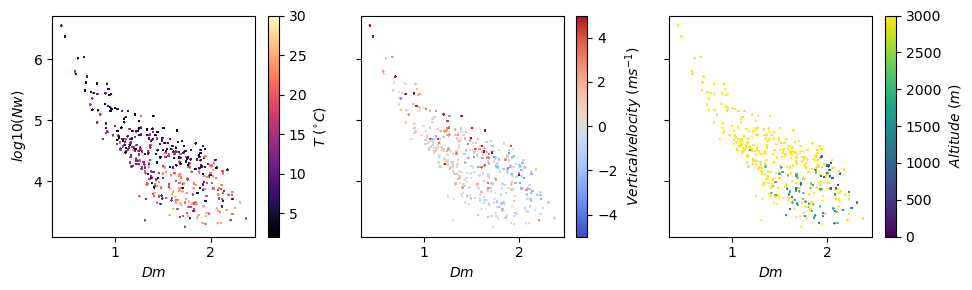

In [46]:
fig, (ax, ax1, ax2) = plt.subplots(1,3, dpi=100, figsize=(10, 3), sharey=True)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['temp'], cmap='magma', vmin=2, vmax=30, s=0.01)
fig.colorbar(sc, ax=ax, label=r'$T \ (^{\circ}C)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$log10(Nw)$')

sc = ax1.scatter(df['dm'], df['log10_nw'], c=df['vert_vel'], cmap='coolwarm', vmin=-5, vmax=5, s=0.01)
fig.colorbar(sc, ax=ax1, label=r'$Vertical velocity \ (ms^{-1})$')
ax1.set_xlabel(r'$Dm$')

sc = ax2.scatter(df['dm'], df['log10_nw'], c=df['altitude'], cmap='viridis', vmin=0, vmax=3000, s=0.01)
fig.colorbar(sc, ax=ax2, label=r'$Altitude \ (m)$')
ax2.set_xlabel(r'$Dm$')

plt.tight_layout()
plt.show()

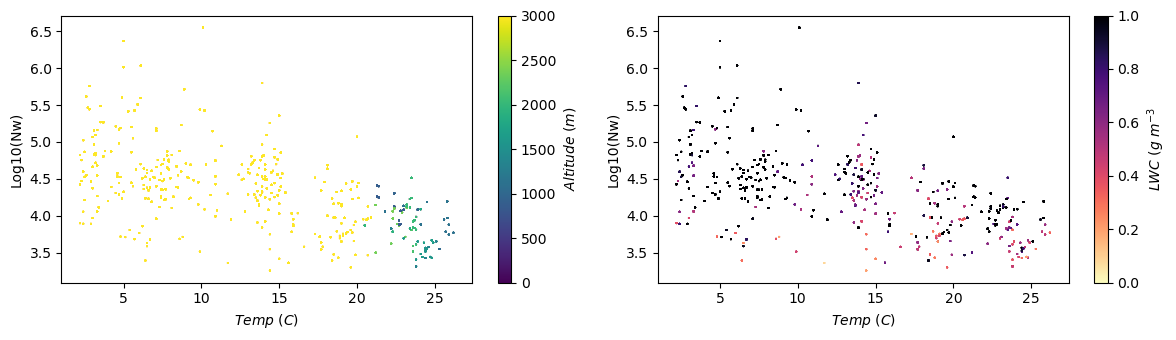

In [47]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['temp'], df['log10_nw'],  c=df['altitude'], cmap='viridis', vmin=0, vmax=3000, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Altitude \ (m)$')
ax.set_ylabel('Log10(Nw)')
ax.set_xlabel(r'$Temp \ (C)$')

sc = ax1.scatter(df['temp'], df['log10_nw'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_ylabel('Log10(Nw)')
ax1.set_xlabel(r'$Temp \ (C)$')
plt.tight_layout()
plt.show()

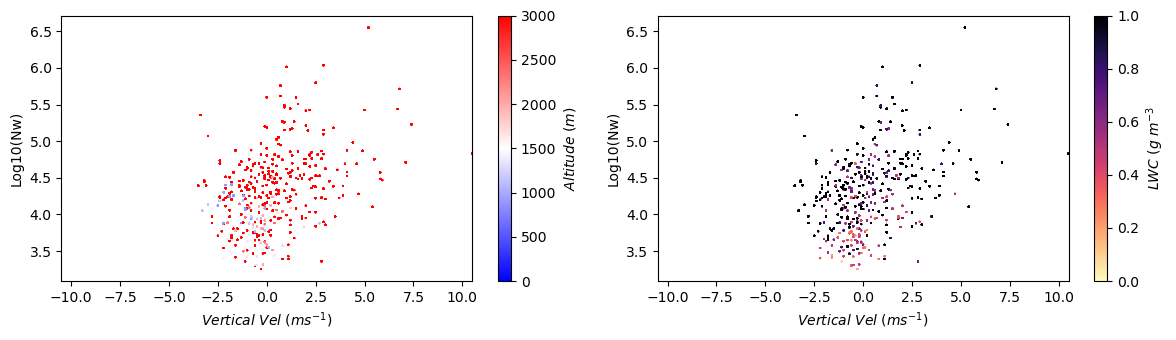

In [48]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['vert_vel'], df['log10_nw'],  c=df['altitude'], cmap='bwr', vmin=0, vmax=3000, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Altitude \ (m)$')
ax.set_ylabel('Log10(Nw)')
ax.set_xlim(-10.5, 10.5)
ax.set_xlabel(r'$Vertical \ Vel \ (m s^{-1})$')

sc = ax1.scatter(df['vert_vel'], df['log10_nw'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_ylabel('Log10(Nw)')
ax1.set_xlim(-10.5, 10.5)
ax1.set_xlabel(r'$Vertical \ Vel \ (m s^{-1})$')
plt.tight_layout()
plt.show()

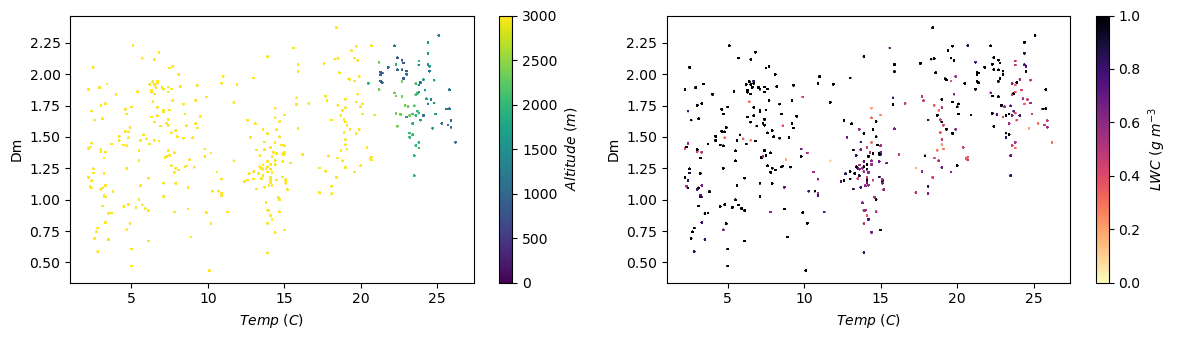

In [49]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['temp'], df['dm'],  c=df['altitude'], cmap='viridis', vmin=0, vmax=3000, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Altitude \ (m)$')
ax.set_ylabel('Dm')
ax.set_xlabel(r'$Temp \ (C)$')

sc = ax1.scatter(df['temp'], df['dm'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_ylabel('Dm')
ax1.set_xlabel(r'$Temp \ (C)$')
plt.tight_layout()
plt.show()

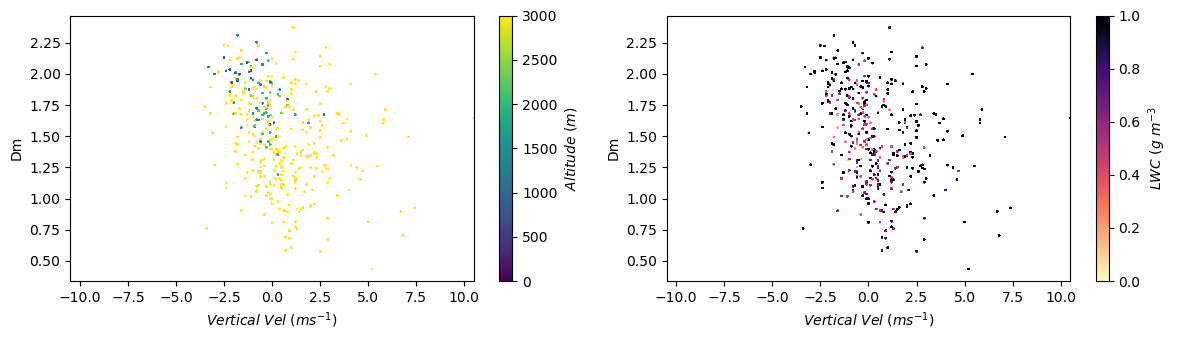

In [50]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['vert_vel'], df['dm'],  c=df['altitude'], cmap='viridis', vmin=0, vmax=3000, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Altitude \ (m)$')
ax.set_ylabel('Dm')
ax.set_xlim(-10.5, 10.5)
ax.set_xlabel(r'$Vertical \ Vel \ (m s^{-1})$')

sc = ax1.scatter(df['vert_vel'], df['dm'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_ylabel('Dm')
ax1.set_xlim(-10.5, 10.5)
ax1.set_xlabel(r'$Vertical \ Vel \ (m s^{-1})$')
plt.tight_layout()
plt.show()

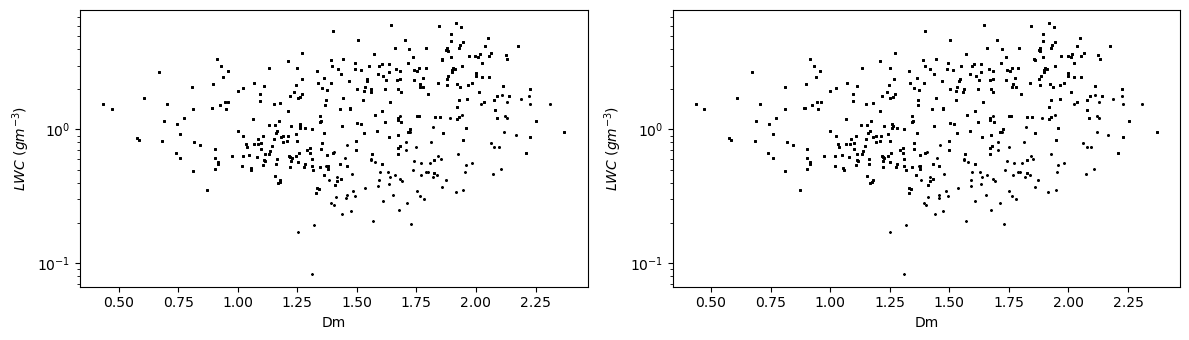

In [51]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['dm'], df['lwc_cum'],  s=0.1 , c='k')
ax.set_yscale('log')
ax.set_xlabel('Dm')
ax1.set_ylabel(r'$LWC \ (gm^{-3})$')

sc = ax1.scatter( df['dm'], df['lwc_cum'], s=0.1, c='k')
ax1.set_yscale('log')
ax1.set_xlabel('Dm')
ax.set_ylabel(r'$LWC \ (gm^{-3})$')
plt.tight_layout()
plt.show()

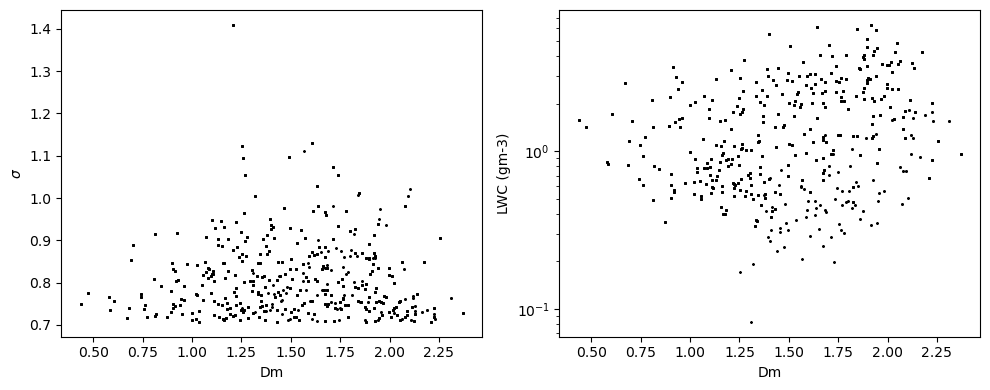

In [52]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(10, 4), sharey=False)
sc = ax.scatter(df['dm'], np.sqrt(df['sigmasqr']),  s=0.1 , c='k')
ax.set_xlabel('Dm')
ax.set_ylabel(r'$\sigma$')

sc1 = ax1.scatter( df['dm'], df['lwc_cum'], s=0.1, c='k')
ax1.set_yscale('log')
ax1.set_ylabel('LWC (gm-3)')
ax1.set_xlabel('Dm')
plt.tight_layout()
plt.show()

In [ ]:
df_sub = df[(df['dm'] > 0.1)]

g0 = sns.jointplot(data=df, x="dm", y='log10_nw', cmap='magma')
g1 = sns.jointplot(data=df_sub, x="dm", y='log10_nw', cmap='magma')
fig = plt.figure(figsize=(13,4))
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
plt.tight_layout()

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
g2 = sns.histplot(data=df, x="dm", y='log10_nw', bins=(50, 50), cmap='magma', 
                     cbar=True, stat='density', ax=ax)
g3 = sns.histplot(data=df_sub, x="dm", y='log10_nw', bins=(50, 50), cmap='magma', 
                     cbar=True, stat='density', ax=ax1)
plt.tight_layout()

In [ ]:
times = df[(df['dm'] <= 0.06)].index.get_level_values(0).unique()

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sns.histplot(data=df_sub, x="dm", y='lwc_cum', bins=(50, 50), cmap='magma', ax=ax, cbar=True,\
             log_scale=(False, True), stat='density', vmin=0, vmax=1)
ax.set_xlabel('Dm')
ax1.set_ylabel(r'$LWC \ (gm^{-3})$')

sns.histplot(data=df, x="dm", y='lwc_cum', bins=(50, 50), cmap='viridis', ax=ax1, cbar=True,\
             log_scale=(False, True), stat='density', vmin=0, vmax=0.5)
ax1.set_yscale('log')
ax1.set_xlabel('Dm')
ax.set_ylabel(r'$LWC \ (gm^{-3})$')
plt.tight_layout()
plt.show()

In [ ]:
df['sigma'] = np.sqrt(df['sigmasqr'])
df_sub['sigma'] = np.sqrt(df_sub['sigmasqr'])

In [ ]:
df = df.replace('-inf', np.nan).dropna()

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sns.histplot(data=df_sub, x="dm", y='lwc_cum', bins=(50, 50), cmap='magma', ax=ax, cbar=True,\
             log_scale=(False, True), stat='density', vmin=0, vmax=0.5)
ax.set_xlabel('Dm')
ax1.set_ylabel(r'$LWC \ (gm^{-3})$')

# sns.histplot(data=df, x="dm", y='sigma', bins=(50, 50), cmap='magma', ax=ax1, cbar=True,\
#              log_scale=(False, True), stat='density', vmin=0, vmax=1)
# ax1.set_yscale('log')
ax1.set_xlabel('Dm')
ax.set_ylabel(r'$LWC \ (gm^{-3})$')
plt.tight_layout()
plt.show()

In [ ]:
df_sub['mu_bins'] = pd.cut(df_sub['mu'], 10)
keys = list(df_sub.groupby(df_sub['mu_bins']).groups.keys())
keys

In [ ]:
fig, ax = plt.subplots(dpi=150)
sc = ax.step(x=df_sub.groupby(df_sub['mu_bins']).get_group(keys[0]).index.get_level_values(1), 
           y=df_sub.groupby(df_sub['mu_bins']).get_group(keys[0])['psd'].replace(0, np.nan))
#            c=df_sub.groupby(df_sub['mu_bins']).get_group(keys[0])['mu'], cmap='jet', s=1) 
ax.set_yscale('log')
ax.set_xscale('log')
fig.colorbar(sc)

In [ ]:
fig, ax = plt.subplots(dpi=150)
sc = ax.scatter(x=df_sub.groupby(df_sub['dm_bins']).get_group(keys[4]).index.get_level_values(1), 
           y=df_sub.groupby(df_sub['dm_bins']).get_group(keys[4])['psd'], 
           c=df_sub.groupby(df_sub['dm_bins']).get_group(keys[4])['mu'], cmap='jet', s=1) 
ax.set_yscale('log')
ax.set_xscale('log')
fig.colorbar(sc)

In [ ]:
fig, ax = plt.subplots(dpi=150)
for row in df_sub.groupby(df_sub['mu_bins']).get_group(keys[0]).head(10).iterrows():
    print(row)
    sc = ax.step(x=row.index.get_level_values(1), 
                 y=row['psd'].replace(0, np.nan))
ax.set_yscale('log')
ax.set_xscale('log')
fig.colorbar(sc)